# Guided mode expansion for a multi-layer grating

In [1]:
import numpy as np
import legume

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Asymmetric grating
In this notebook we will reproduce some of the results from the paper "Perfect single-sided radiation and absorption without mirrors", Zhou et al., Optica 3 (2016). We first initialize an asymmetric grating as shown in Fig. 2(a) of the paper.

In [2]:
# Grating parameters as for Fig. 3 (b)
ymax = 0.1      # ficticious supercell length in y-direction, should be smaller than 1/gmax below
W = 0.45        # width of dielectric rods
H = 1.5         # total height of grating
D = 0.1         # thickness of added parts
Wa = (1-W)/2    # width of added parts
epss = 1.45**2  # permittivity of the rods
epsa = 1.1**2   # permittivity of the added parts

## Build the grating as a three-layer structure

The grating can be initialized as a three-layer photonic crystal. We take a rectangular lattice with a small periodicity in the y-direction. If `ymax < 1/gmax`, then only reciprocal lattice vectors with $G_y = 0$ will be included in the expansion, as should be for a grating.

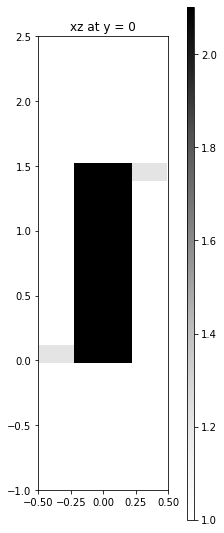

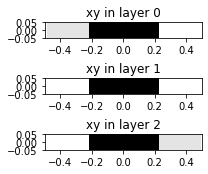

In [5]:
# Initialize the lattice and the PhC
lattice = legume.Lattice([1, 0], [0, ymax])
phc = legume.PhotCryst(lattice)

# First layer
phc.add_layer(d=D, eps_b=epss)
rect_add = legume.Poly(eps=epsa, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_air = legume.Poly(eps=1, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_add, rect_air])

# Second layer
phc.add_layer(d=H-2*D, eps_b=epss)
rect_air1 = legume.Poly(eps=1, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_air2 = legume.Poly(eps=1, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_air1, rect_air2])

# Third layer
phc.add_layer(d=D, eps_b=epss)
rect_air = legume.Poly(eps=1, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_add = legume.Poly(eps=epsa, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_add, rect_air])

# Visualize what we built
legume.viz.structure(phc, xz=True, xy=False, figsize=3)
legume.viz.structure(phc, figsize=6., cbar=False)

## Compute quasi-guided bands

We first compute the bnads in the entire Brillouin zone. In this grating, the symmetry w.r.t. the kz plane is always satisfied, and the TE/TM classification is valid. However, the definition is ambiguous. In our notation, relevant for 2D PhC-s, the classification is w.r.t. the xy-plane. In Zhou et al., the classification is w.r.t. the kz plane. Thus, what they call TE, we call TM. To put it more explicitly, we will simulate modes where $H_y$ is the only nonzero magnetic field component.

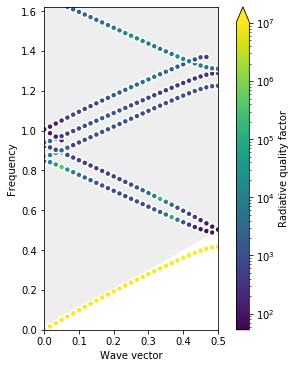

In [4]:
# Make a BZ path along the G-X direction
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [30])

neig = 7 # number of Bloch bands to store
gmax = 4 # truncation of reciprocal lattice vectors

# Initialize GME
gme = legume.GuidedModeExp(phc, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [1, 3, 5, 7], # Take only the modes with H in the xy-plane
           'numeig': neig, 
           'verbose': False
            }

# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

# Visualize the bands
ax = legume.viz.bands(gme, Q=True)

## Asymmetric coupling

Next, as they do in the paper, we focus on a region close to $\Gamma$, and on the first quasi-guided band inside the lighg-cone (the one starting at frequency ~ 0.84 and going down). The frequency of this band is shown in Fig. S4 in the Supplementary of the paper, while the quality factor is shown in Fig. 3(b).

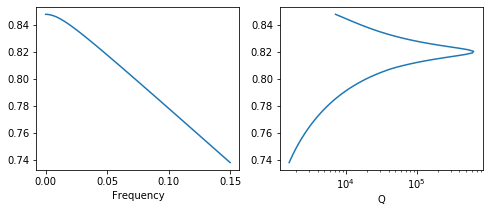

In [5]:
# Make a path that matches the axis extent in the paper, and put 100 k-points to capture the quasi-BIC well
path = phc.lattice.bz_path(['G', 0.15*np.array([2*np.pi, 0])], [100])

neig = 2 # number of Bloch bands to store
gmax = 6 # truncation of reciprocal lattice vectors

# Initialize GME
gme = legume.GuidedModeExp(phc, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [1, 3, 5, 7], # Take only the modes with H in the xy-plane
           'numeig': neig, 
           'verbose': False
            }

# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

# Plot the frequency and the quality factor
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
indmode = 1
ax[0].plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode])
ax[0].set_xlabel('Wave vector')
ax[0].set_xlabel('Frequency')
ax[1].plot(gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode], gme.freqs[:, indmode])
ax[1].set_xscale('log')
ax[1].set_xlabel('Q');

Finally, we reproduce Fig. 3(b) from the paper. Note that the `legume` GME method computes the coupling constant of each Bloch mode to plane waves outgoing in the lower and in the upper cladding, for TE- and TM-polarized outgoing light (equvalently, S and P polarization, respectively). These are stored in the dictionary `gme.rad_coup`, with keys `'l_te'`, `'l_tm'`, `'u_te'`, and `'u_tm'`. Each item is a list of `Nk` lists of `numeig` elements, giving the coupling constants at each `k` for each mode. Finally, the elements are numpy arrays with as many elements as there are allowed diffraction orders, with the corresponding reciprocal lattice vectors stored in `gme.rad_gvec`.

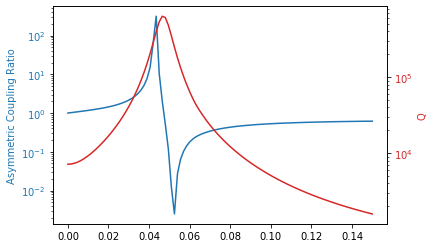

In [14]:
Nk = gme.kpoints[0, :].size
# Coupling constant to lower-cladding TM modes 
dl = np.array([gme.rad_coup['l_tm'][ik][1] for ik in range(Nk)])
# Coupling constant to upper-cladding TM modes 
du = np.array([gme.rad_coup['u_tm'][ik][1] for ik in range(Nk)])
# Note: the coupling to TE modes is zero because of the kz symmetry

fig, ax = plt.subplots(1)
# Plot the asymmetric coupling ratio
color = 'tab:blue'
ax.plot(gme.kpoints[0, :]/2/np.pi, np.abs(dl/du)**2)
ax.set_yscale('log')
ax.set_ylabel('Asymmetric Coupling Ratio', color=color)
ax.tick_params(axis='y', labelcolor=color)

# Plot the quality factor
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode], color=color)
ax2.set_yscale('log')
ax2.set_ylabel('Q', color=color)
ax2.tick_params(axis='y', labelcolor=color)

The agreement with Fig. 3(b) of Zhou et al., Optica (2016) is not *perfect*: for example, the BIC as computed by `legume` occurs slightly closer to the $\Gamma$ point. However, the agreement is still quite good, and the important physics is captured.

![](img/grating_asymmetric.png)